<a href="https://colab.research.google.com/github/bala1802/ERA-Session-11/blob/main/Session_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
cd /content/drive/MyDrive/Session-11-Working

/content/drive/MyDrive/Session-11-Working


In [2]:
!ls

ERA-Session-11


In [3]:
# !git clone https://github.com/bala1802/ERA-Session-11.git
# !git pull

In [3]:
cd ERA-Session-11/

/content/drive/MyDrive/Session-11-Working/ERA-Session-11


In [4]:
!ls

data  LICENSE  README.md  requirements.txt  torchtools


#### Install Packages

In [5]:
from IPython.display import clear_output
!pip install -r requirements.txt
clear_output()
%cd /content/

/content


In [6]:
cd /content/drive/MyDrive/Session-11-Working/ERA-Session-11

/content/drive/MyDrive/Session-11-Working/ERA-Session-11


#### Import Libraries

In [24]:
import albumentations as A
import torch
import torch.optim as optim
from albumentations.pytorch import ToTensorV2
from torchvision import transforms as T
from torch.nn import CrossEntropyLoss
from torch.optim.lr_scheduler import OneCycleLR

from torchtools.dataset import build_cifar
from torchtools.dataset import make_transform
from torchtools.models import custom_resnet
from torchtools.utils.misc import find_lr
from torchtools.utils.misc import per_class_accuracy
from torchtools.utils.plotting import plot_misclassified
from torchtools.utils import gradcam
from torchtools.trainer import Trainer
from torchtools.models.custom_resnet import ResNet18
from torchtools.utils.gradcam import plot_cam_on_image

#### Load Data

In [8]:
batch_size = 512

kwargs = {
    "batch_size": batch_size,
    "shuffle": True,
    "num_workers": 2,
    "pin_memory": True,
}
mean = (0.49139968, 0.48215841, 0.44653091)
std = (0.24703223, 0.24348513, 0.26158784)
train_transforms = A.Compose(
    [
        A.Sequential(
            [
                A.CropAndPad(px=4, keep_size=False),  # padding of 2, keep_size=True by defaulf
                A.RandomCrop(32, 32),
            ]
        ),
        A.CoarseDropout(1, 16, 16, 1, 16, 16, fill_value=mean, mask_fill_value=None),
        A.Normalize(mean, std),
        ToTensorV2(),
    ]
)
train_loader = build_cifar(set="train", augments=train_transforms, **kwargs)
test_loader = build_cifar(set="test", **kwargs)

Files already downloaded and verified
Files already downloaded and verified


#### Configure device

In [9]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


#### Initialize Model

In [10]:
model = ResNet18().to(device)
model.summarize(device, (1, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 10]                   --
├─Conv2d: 1-1                            [1, 64, 32, 32]           1,728
├─BatchNorm2d: 1-2                       [1, 64, 32, 32]           128
├─Sequential: 1-3                        [1, 64, 32, 32]           --
│    └─BasicBlock: 2-1                   [1, 64, 32, 32]           --
│    │    └─Conv2d: 3-1                  [1, 64, 32, 32]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 32, 32]           128
│    │    └─Conv2d: 3-3                  [1, 64, 32, 32]           36,864
│    │    └─BatchNorm2d: 3-4             [1, 64, 32, 32]           128
│    │    └─Sequential: 3-5              [1, 64, 32, 32]           --
│    └─BasicBlock: 2-2                   [1, 64, 32, 32]           --
│    │    └─Conv2d: 3-6                  [1, 64, 32, 32]           36,864
│    │    └─BatchNorm2d: 3-7             [1, 64, 32, 32]           

#### Load Optimizers

In [11]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

#### LR Scheduler

  0%|          | 0/200 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.15E-02


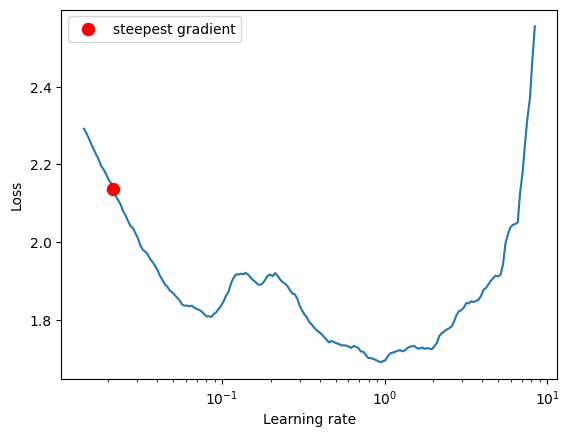

In [12]:
kwargs = {"end_lr": 10, "num_iter": 200, "step_mode": "exp"}
find_lr(model, device, optimizer, criterion=CrossEntropyLoss(), dataloader=train_loader, **kwargs)

In [13]:
num_epochs = 20

scheduler = OneCycleLR(
    optimizer,
    max_lr=2.15E-02,
    steps_per_epoch=len(train_loader),
    epochs=num_epochs,
    pct_start=5 / num_epochs,
    div_factor=100,
    three_phase=False,
    final_div_factor=100,
    anneal_strategy="linear",
)

# scheduler = None
trainer = Trainer(model, device, optimizer, scheduler)
for epoch in range(1, num_epochs + 1):
    print(f"Epoch {epoch}")
    trainer.train(train_loader)
    trainer.evaluate(test_loader)

Epoch 1


Train: Loss=1.6040 Batch_id=97 Accuracy=27.46: 100%|██████████| 98/98 [00:48<00:00,  2.03it/s]


Test set: Average loss: 1.5938, Accuracy: 4186/10000 (41.86%)

Epoch 2


Train: Loss=1.2625 Batch_id=97 Accuracy=47.11: 100%|██████████| 98/98 [00:48<00:00,  2.01it/s]


Test set: Average loss: 1.3278, Accuracy: 5378/10000 (53.78%)

Epoch 3


Train: Loss=1.0897 Batch_id=97 Accuracy=57.47: 100%|██████████| 98/98 [00:49<00:00,  1.98it/s]


Test set: Average loss: 1.2302, Accuracy: 5913/10000 (59.13%)

Epoch 4


Train: Loss=1.0125 Batch_id=97 Accuracy=63.69: 100%|██████████| 98/98 [00:50<00:00,  1.95it/s]


Test set: Average loss: 1.2399, Accuracy: 5907/10000 (59.07%)

Epoch 5


Train: Loss=0.8502 Batch_id=97 Accuracy=69.40: 100%|██████████| 98/98 [00:50<00:00,  1.93it/s]


Test set: Average loss: 1.0346, Accuracy: 6713/10000 (67.13%)

Epoch 6


Train: Loss=0.8808 Batch_id=97 Accuracy=73.41: 100%|██████████| 98/98 [00:50<00:00,  1.96it/s]


Test set: Average loss: 0.7262, Accuracy: 7544/10000 (75.44%)

Epoch 7


Train: Loss=0.5686 Batch_id=97 Accuracy=76.47: 100%|██████████| 98/98 [00:50<00:00,  1.94it/s]


Test set: Average loss: 0.8048, Accuracy: 7456/10000 (74.56%)

Epoch 8


Train: Loss=0.5414 Batch_id=97 Accuracy=78.66: 100%|██████████| 98/98 [00:49<00:00,  1.96it/s]


Test set: Average loss: 0.8769, Accuracy: 7516/10000 (75.16%)

Epoch 9


Train: Loss=0.5554 Batch_id=97 Accuracy=80.48: 100%|██████████| 98/98 [00:49<00:00,  1.96it/s]


Test set: Average loss: 0.6699, Accuracy: 7908/10000 (79.08%)

Epoch 10


Train: Loss=0.4952 Batch_id=97 Accuracy=81.78: 100%|██████████| 98/98 [00:49<00:00,  1.97it/s]


Test set: Average loss: 0.6484, Accuracy: 7928/10000 (79.28%)

Epoch 11


Train: Loss=0.4875 Batch_id=97 Accuracy=83.55: 100%|██████████| 98/98 [00:49<00:00,  1.96it/s]


Test set: Average loss: 0.4990, Accuracy: 8401/10000 (84.01%)

Epoch 12


Train: Loss=0.4958 Batch_id=97 Accuracy=84.23: 100%|██████████| 98/98 [00:49<00:00,  1.98it/s]


Test set: Average loss: 0.5943, Accuracy: 8136/10000 (81.36%)

Epoch 13


Train: Loss=0.4186 Batch_id=97 Accuracy=85.33: 100%|██████████| 98/98 [00:50<00:00,  1.95it/s]


Test set: Average loss: 0.6161, Accuracy: 8130/10000 (81.30%)

Epoch 14


Train: Loss=0.3713 Batch_id=97 Accuracy=86.39: 100%|██████████| 98/98 [00:50<00:00,  1.95it/s]


Test set: Average loss: 0.4927, Accuracy: 8463/10000 (84.63%)

Epoch 15


Train: Loss=0.3740 Batch_id=97 Accuracy=87.54: 100%|██████████| 98/98 [00:50<00:00,  1.95it/s]


Test set: Average loss: 0.5156, Accuracy: 8487/10000 (84.87%)

Epoch 16


Train: Loss=0.3070 Batch_id=97 Accuracy=88.45: 100%|██████████| 98/98 [00:50<00:00,  1.94it/s]


Test set: Average loss: 0.4504, Accuracy: 8625/10000 (86.25%)

Epoch 17


Train: Loss=0.3131 Batch_id=97 Accuracy=89.40: 100%|██████████| 98/98 [00:50<00:00,  1.96it/s]


Test set: Average loss: 0.4772, Accuracy: 8582/10000 (85.82%)

Epoch 18


Train: Loss=0.2225 Batch_id=97 Accuracy=90.55: 100%|██████████| 98/98 [00:50<00:00,  1.96it/s]


Test set: Average loss: 0.4181, Accuracy: 8781/10000 (87.81%)

Epoch 19


Train: Loss=0.2403 Batch_id=97 Accuracy=91.58: 100%|██████████| 98/98 [00:50<00:00,  1.95it/s]


Test set: Average loss: 0.3501, Accuracy: 8936/10000 (89.36%)

Epoch 20


Train: Loss=0.1935 Batch_id=97 Accuracy=92.57: 100%|██████████| 98/98 [00:49<00:00,  1.97it/s]


Test set: Average loss: 0.3193, Accuracy: 9025/10000 (90.25%)



#### Plot the History of loss and accuracy for the epochs observed

Set	 Max Acc@Epoch	 Last Epoch Acc
train	 92.57@20		92.57
test	 90.25@20		90.25


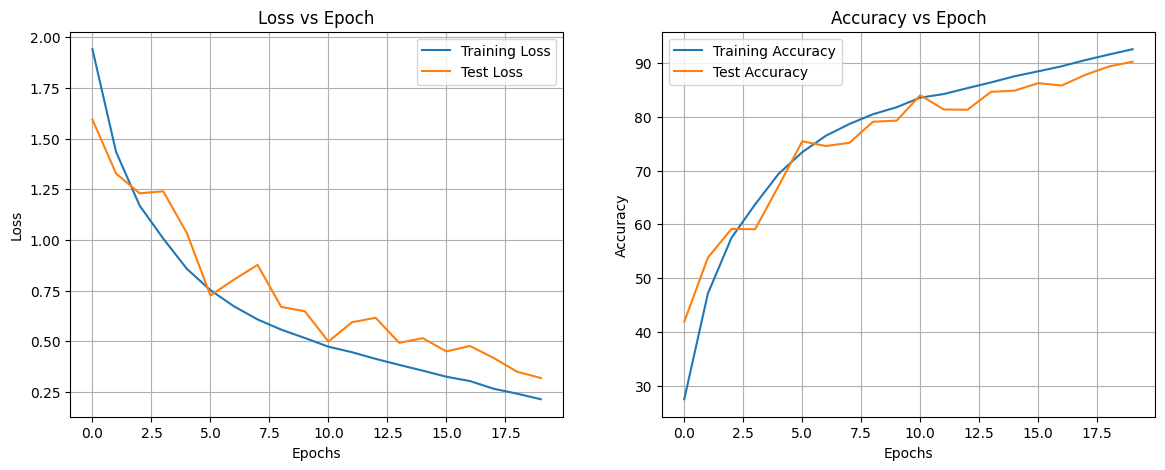

In [14]:
trainer.plot_history()

#### Evaluate

In [17]:
test_transforms = make_transform("test")

In [20]:
per_class_accuracy(model, device, test_loader)

[x] Accuracy of :
	[*] airplane : 94 %
	[*] automobile : 100 %
	[*]     bird : 82 %
	[*]      cat : 81 %
	[*]     deer : 96 %
	[*]      dog : 90 %
	[*]     frog : 82 %
	[*]    horse : 92 %
	[*]     ship : 94 %
	[*]    truck : 86 %


#### Plot the Misclassified Images

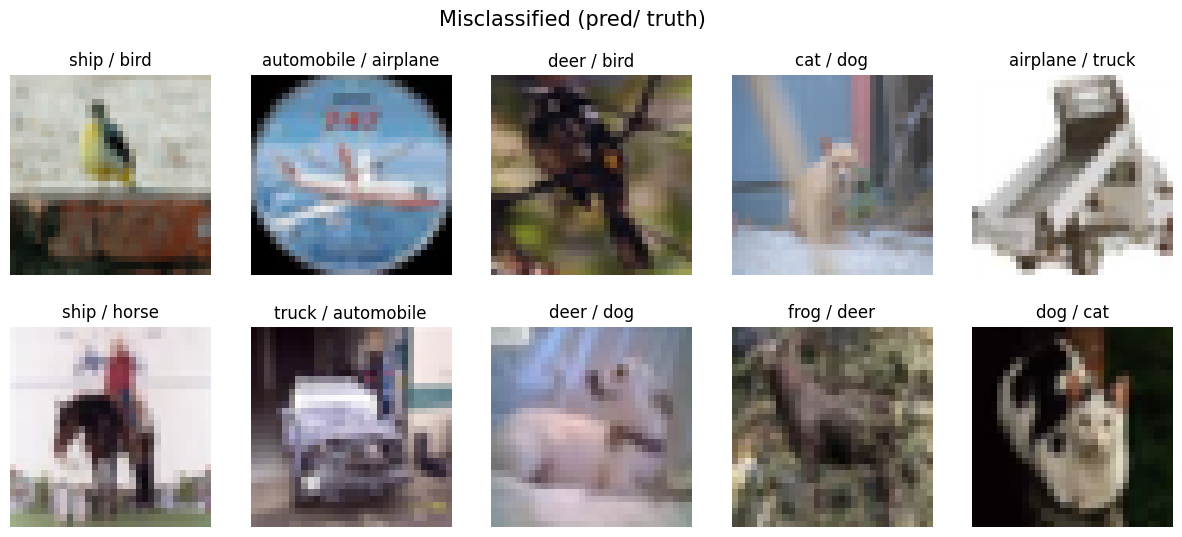

In [21]:
misclassified_imgs = plot_misclassified(
    model, test_loader, device, test_transforms, return_imgs=True
)

#### GradCAM results

In [22]:
model.layer4[1]

BasicBlock(
  (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (shortcut): Sequential()
)

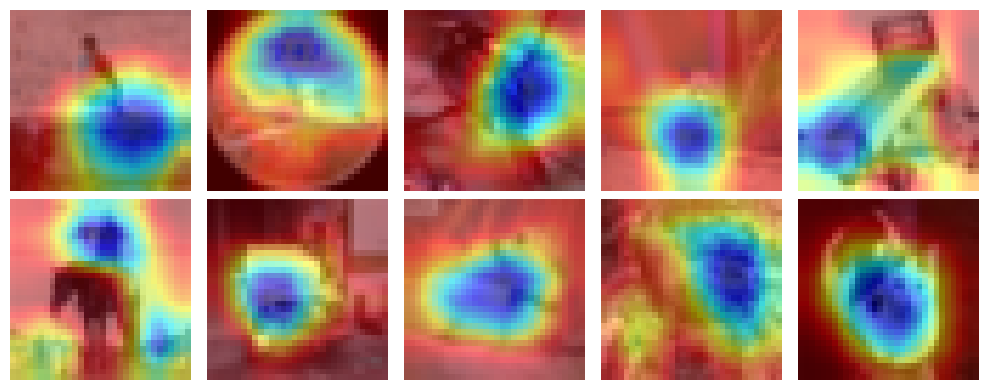

In [25]:
plot_cam_on_image(model, [model.layer4[1]], misclassified_imgs, {"mean": mean, "std": std})